In [132]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../source")))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils.custom_classes.GarbageClassifier import GarbageClassifier
from utils.custom_classes.GarbageDataModule import GarbageDataModule
from utils import config as cfg

In [133]:
with open("../data/o/loss_curves/metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
val_accs = metrics["val_accs"]

In [134]:
print(len(train_losses), len(val_losses))

3 3


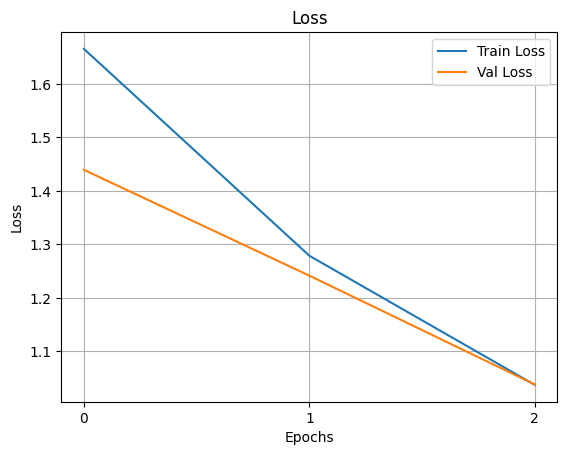

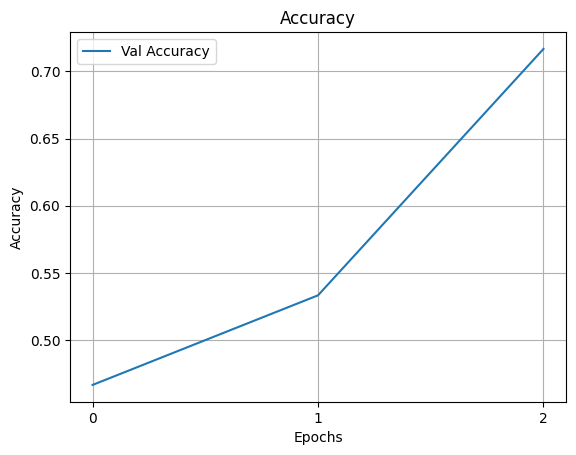

In [135]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss")
plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.show()

plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy")
plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.show()

In [136]:
print(f"Loading model...")
model = GarbageClassifier.load_from_checkpoint(cfg.MODEL_PATH, num_classes = cfg.NUM_CLASSES)
print(f"Done")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

Loading model...
Done


GarbageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [52]:
data_module = GarbageDataModule(batch_size=32)
data_module.setup()

val_loader = data_module.val_dataloader()

In [63]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)                  # logits
        preds = out.argmax(dim=1)        # classes
        probs = torch.softmax(out, dim=1)# probabilities
        all_probs.append(probs.cpu())
        all_preds.append(preds)
        all_labels.append(yb)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs).numpy()

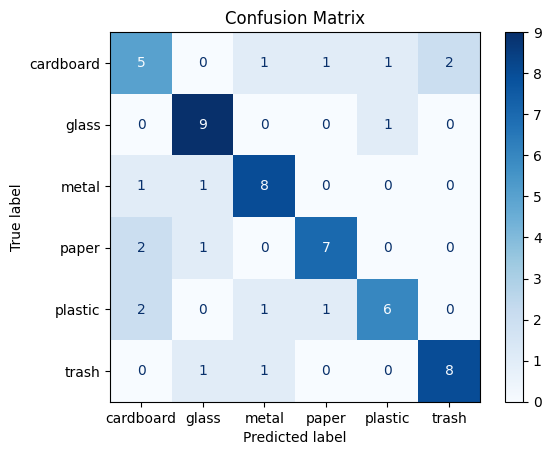

Clase 0: TP=5, FP=5, FN=5, TN=45
Clase 1: TP=9, FP=3, FN=1, TN=47
Clase 2: TP=8, FP=3, FN=2, TN=47
Clase 3: TP=7, FP=2, FN=3, TN=48
Clase 4: TP=6, FP=2, FN=4, TN=48
Clase 5: TP=8, FP=2, FN=2, TN=48


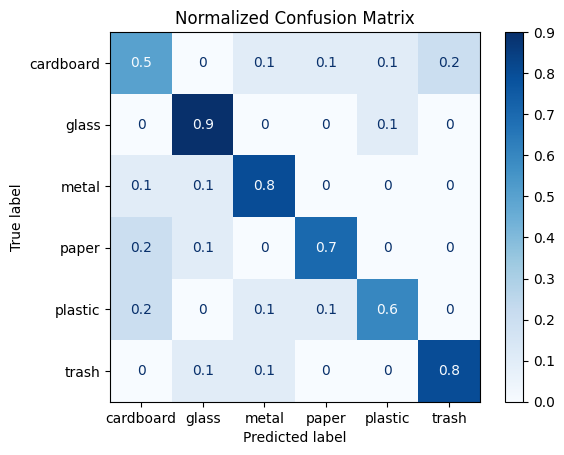

In [87]:
num_classes = data_module.num_classes

# ================================
# Confussion Matrix
# ================================
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(cfg.CLASS_NAMES))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ================================
# TP, FP, FN, TN per class
# ================================
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(num_classes):
    print(f"Clase {i}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")

# ================================
# Normalized Confussion Matrix
# ================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=(cfg.CLASS_NAMES))
disp_norm.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.show()

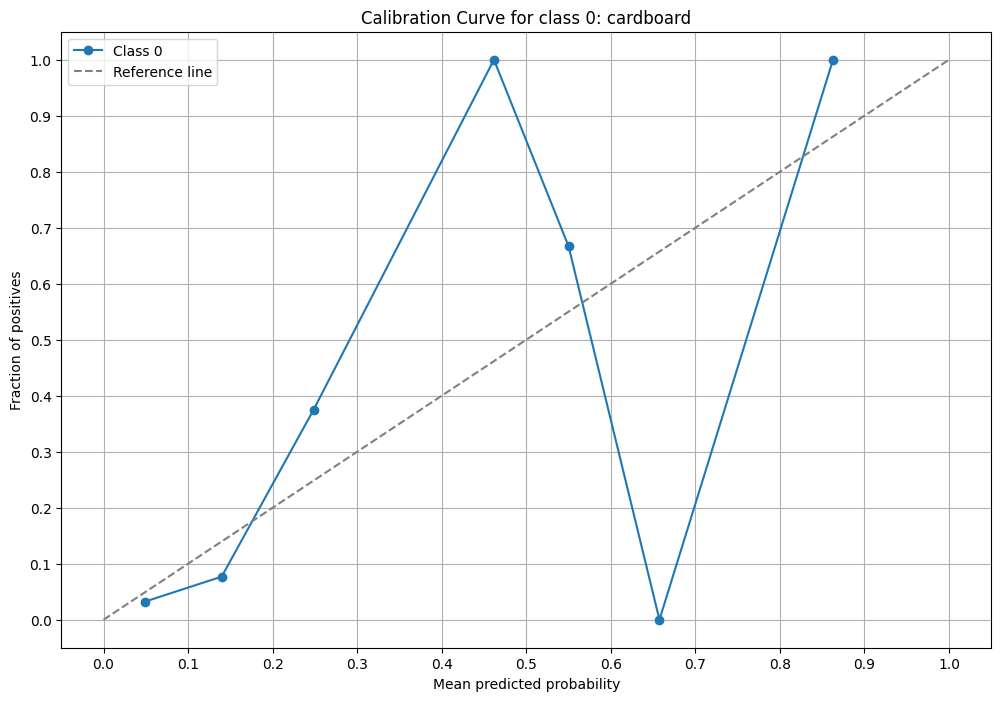

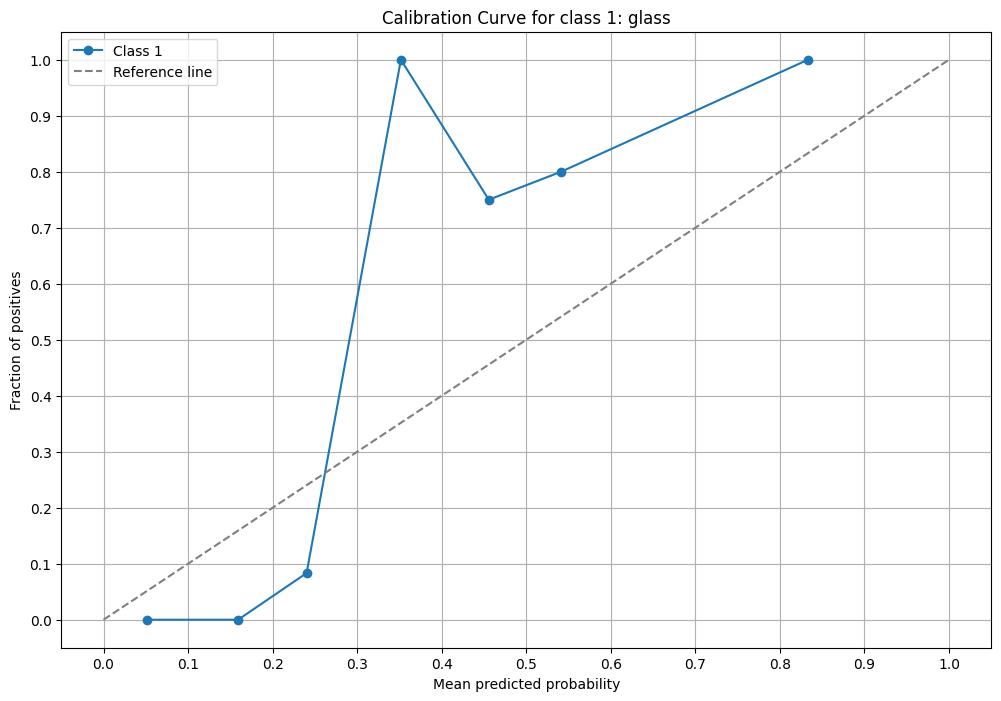

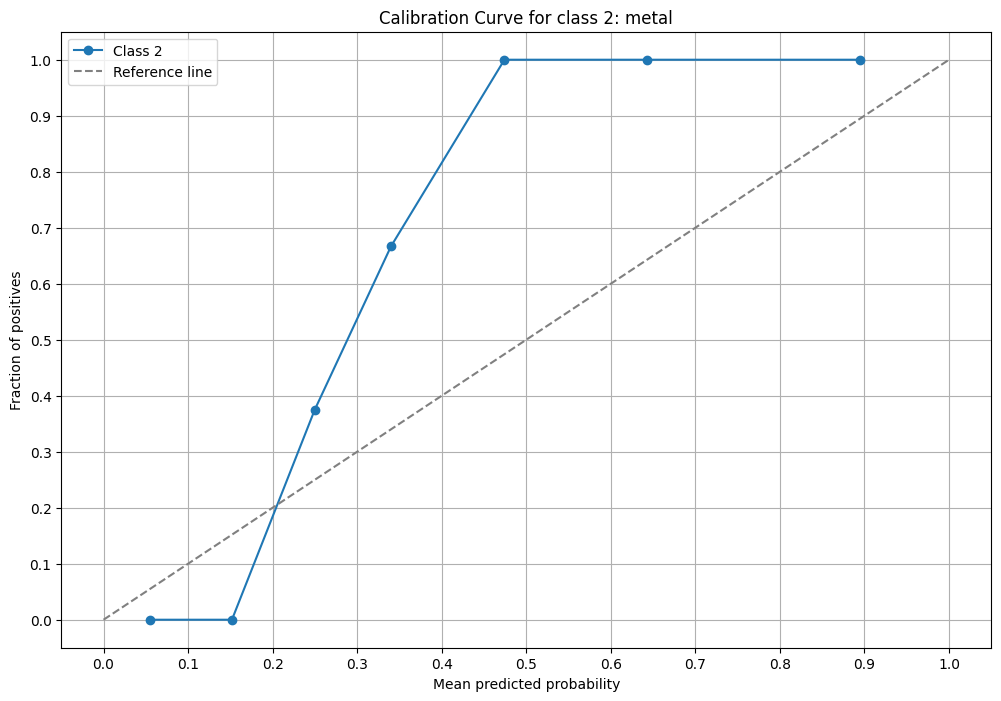

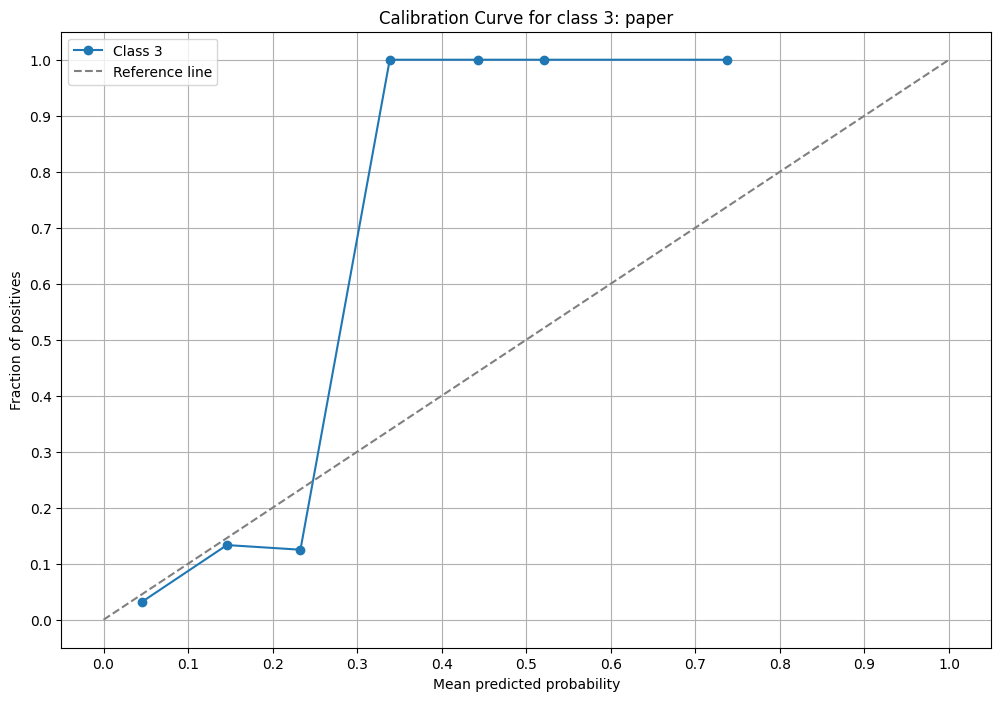

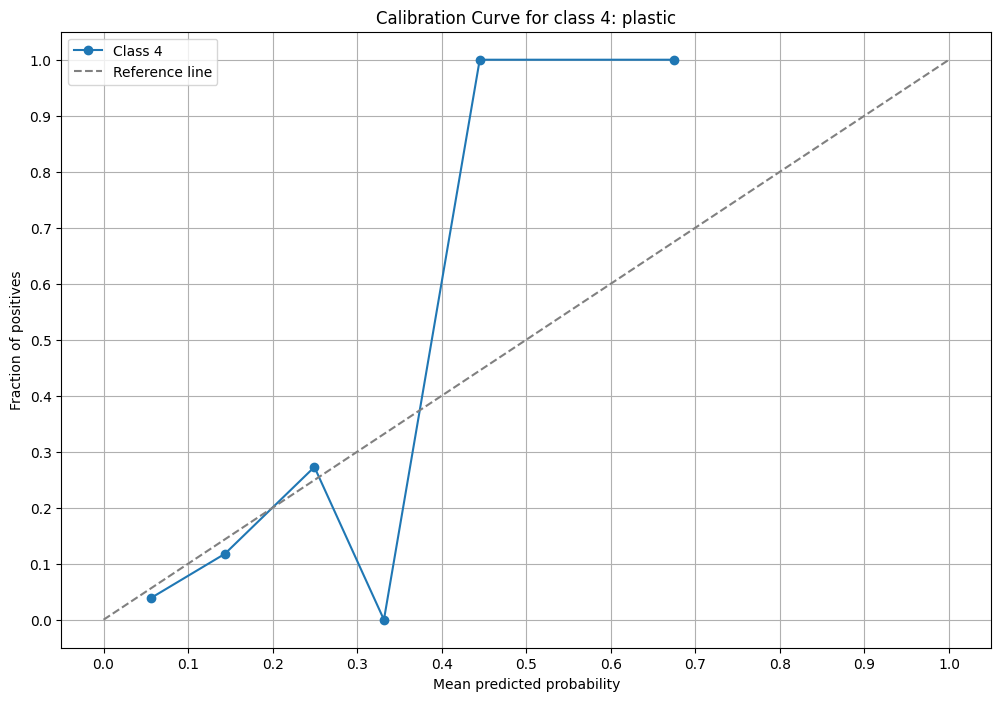

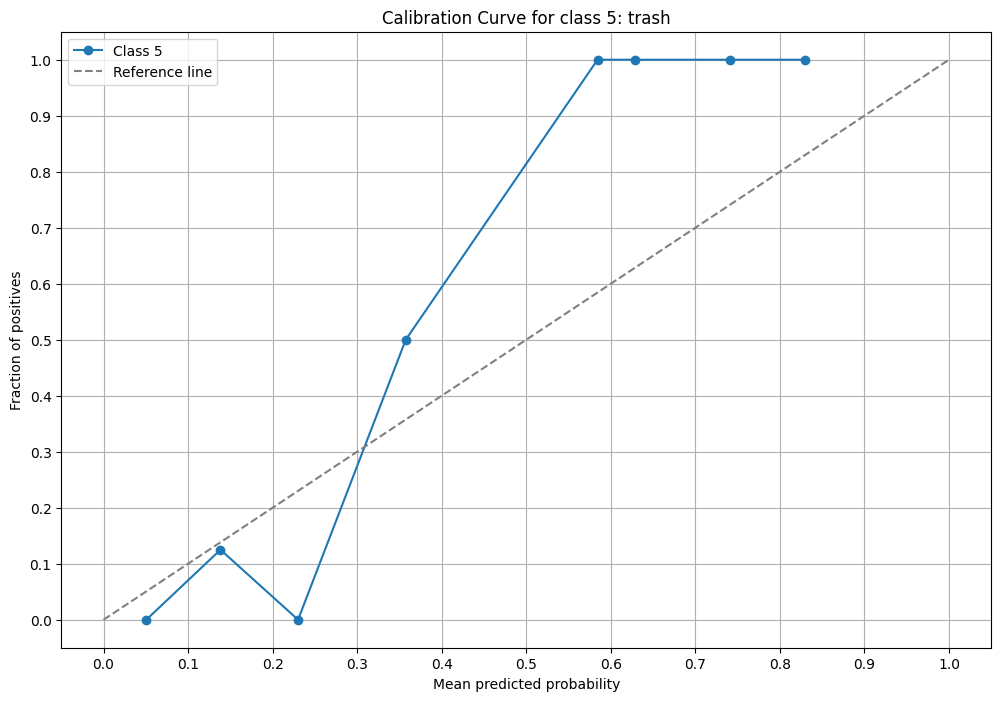

In [121]:
# ================================
# Calibration curves per class
# ================================

for c in range(num_classes):
    plt.figure(figsize=(12, 8))
    
    # y_true: 1 if sample is clase c, else 0
    y_true = (all_labels.numpy() == c).astype(int)
    y_prob = all_probs[:, c]
    
    # calibration_curve returns fraction_of_positives and mean_predicted_value
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    
    plt.plot(mean_pred, frac_pos, marker='o', label=f'Class {c}')

    # Reference line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label = 'Reference line')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curve for class {c}: {cfg.CLASS_NAMES[c]}")
    plt.legend()
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.show()

           0.00-0.10  0.10-0.20  0.20-0.30  0.30-0.40  0.40-0.50  0.50-0.60  \
cardboard   0.032258   0.076923   0.375000        NaN       1.00   0.666667   
glass       0.000000   0.000000   0.083333   1.000000       0.75   0.800000   
metal       0.000000   0.000000   0.375000   0.666667       1.00        NaN   
paper       0.032258   0.133333   0.125000   1.000000       1.00   1.000000   
plastic     0.038462   0.117647   0.272727   0.000000       1.00        NaN   
trash       0.000000   0.125000   0.000000   0.500000        NaN   1.000000   

           0.60-0.70  0.70-0.80  0.80-0.90  0.90-1.00  
cardboard        0.0        NaN        1.0        NaN  
glass            NaN        NaN        1.0        NaN  
metal            1.0        NaN        1.0        NaN  
paper            NaN        1.0        NaN        NaN  
plastic          1.0        NaN        NaN        NaN  
trash            1.0        1.0        1.0        NaN  


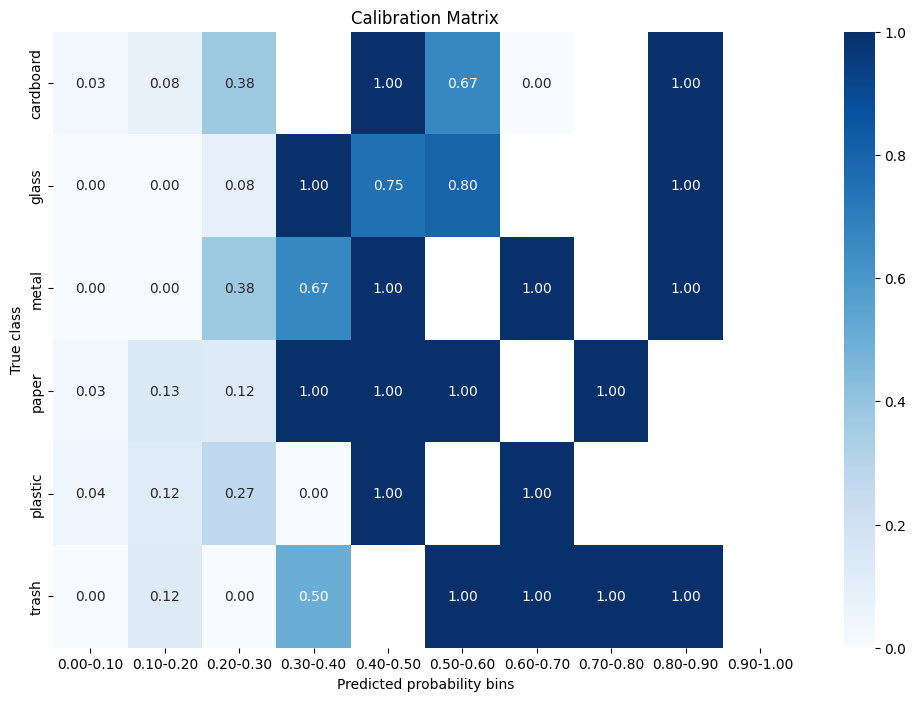

In [125]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)
calib_matrix = np.zeros((num_classes, n_bins))

for c in range(num_classes):
    y_true = (all_labels.numpy() == c).astype(int)
    y_prob = all_probs[:, c]
    
    # Digitize probabilities into bins
    bin_indices = np.digitize(y_prob, bins) - 1  
    
    for b in range(n_bins):
        if np.sum(bin_indices == b) > 0:
            frac_pos = y_true[bin_indices == b].mean()
            calib_matrix[c, b] = frac_pos
        else:
            calib_matrix[c, b] = np.nan  # no samples for that bin

# Convert to DataFrame
bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(n_bins)]
calib_df = pd.DataFrame(calib_matrix, index=cfg.CLASS_NAMES, columns=bin_labels)
print(calib_df)

plt.figure(figsize=(12,8))
sns.heatmap(calib_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted probability bins")
plt.ylabel("True class")
plt.title("Calibration Matrix")
plt.show()
